In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, Callback
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import backend as K

In [36]:
# Configurer TensorFlow pour utiliser le GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [37]:
# Activer la précision mixte
from tensorflow.keras.mixed_precision import Policy
policy = Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [38]:
# Nettoyage de la mémoire (au cas où :D)
K.clear_session()

In [39]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 50
CWD = Path.cwd()
NEW_TRAIN = CWD / "sorted_data" / "train"
NEW_VAL = CWD / "sorted_data" / "val"
NEW_TEST = CWD / "sorted_data" / "test"
class_names = {0: 'NORMAL', 1: 'VIRUS', 2: 'BACTERIA'}

In [40]:
# Utiliser image_dataset_from_directory pour charger les datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TRAIN,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_VAL,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=NEW_TEST,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Appliquer le prétraitement spécifique à VGG16
def preprocess(image, label):
    return preprocess_input(image), label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(buffer_size=1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 12484 files belonging to 3 classes.
Found 288 files belonging to 3 classes.
Found 822 files belonging to 3 classes.


In [41]:
# Augmentation des données
from tensorflow.keras.layers import RandomFlip, RandomRotation

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

In [42]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten(name='new_flatten')(x)
x = Dense(320, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(320, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
classifieur = Dense(3, activation='softmax', dtype='float32')(x)  # 3 classes: NORMAL, BACTERIA, VIRUS

new_model = Model(inputs=base_model.input, outputs=classifieur)

In [43]:
# Geler les couches de base
for layer in base_model.layers:
    layer.trainable = False

In [44]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 8,133,443 (31.03 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [45]:
# Callbacks pour l'entraînement
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))

In [46]:
lr_scheduler = LearningRateScheduler(scheduler)

In [47]:
es = EarlyStopping(
    monitor="val_loss", 
    mode="min", 
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Callback pour évaluation intermédiaire
class IntermediateEvaluation(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Evaluate every 5 epochs
            test_loss, test_accuracy, test_recall = self.model.evaluate(test_dataset)
            print(f"Epoch {epoch} - Test loss: {test_loss}, Test accuracy: {test_accuracy}, Test recall: {test_recall}")

In [48]:
callbacks = [es, reduce_lr, lr_scheduler, IntermediateEvaluation()]

history = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/50


2024-07-07 13:04:07.027643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:64: Filling up shuffle buffer (this may take a while): 493 of 1000
2024-07-07 13:04:12.766842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.8554 - loss: 1.3442 - recall: 0.8396
Epoch 0 - Test loss: 1.4756590127944946, Test accuracy: 0.7968369722366333, Test recall: 0.7773722410202026
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 100s 51ms/step - accuracy: 0.5358 - loss: 2.3136 - recall: 0.5147 - val_accuracy: 0.7014 - val_loss: 1.6199 - val_recall: 0.6840 - learning_rate: 1.0000e-04
Epoch 2/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.6402 - loss: 1.8778 - recall: 0.6231 - val_accuracy: 0.7153 - val_loss: 1.5511 - val_recall: 0.6910 - learning_rate: 1.0000e-04
Epoch 3/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.6694 - loss: 1.7070 - recall: 0.6518 - val_accuracy: 0.7118 - val_loss: 1.4313 - val_recall: 0.6910 - learning_rate: 1.0000e-04
Epoch 4/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.6858 - loss: 1.5743 - recall: 0.6683 - val_accuracy: 0.7257 - val_loss: 1.3372 - val_recall: 0.7083 - learning_rate: 1.0000e-04
Epoch 5/50
1561/1

In [49]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8876 - loss: 0.5620 - recall: 0.8778
Loss on test dataset: 0.7598941326141357
Accuracy on test dataset: 0.8029196858406067
Recall on test dataset: 0.7956204414367676


In [50]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [51]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

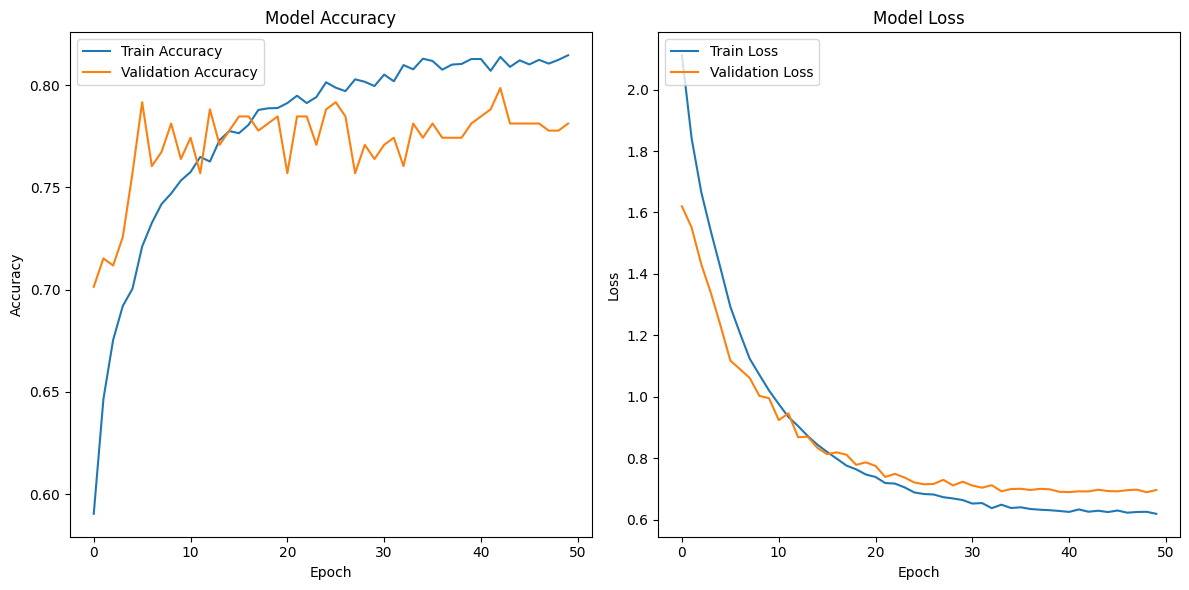

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8876 - loss: 0.5620 - recall: 0.8778
Loss on test dataset: 0.7598941326141357
Accuracy on test dataset: 0.8029196858406067
Recall on test dataset: 0.7956204414367676


2024-07-07 14:02:43.524746: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


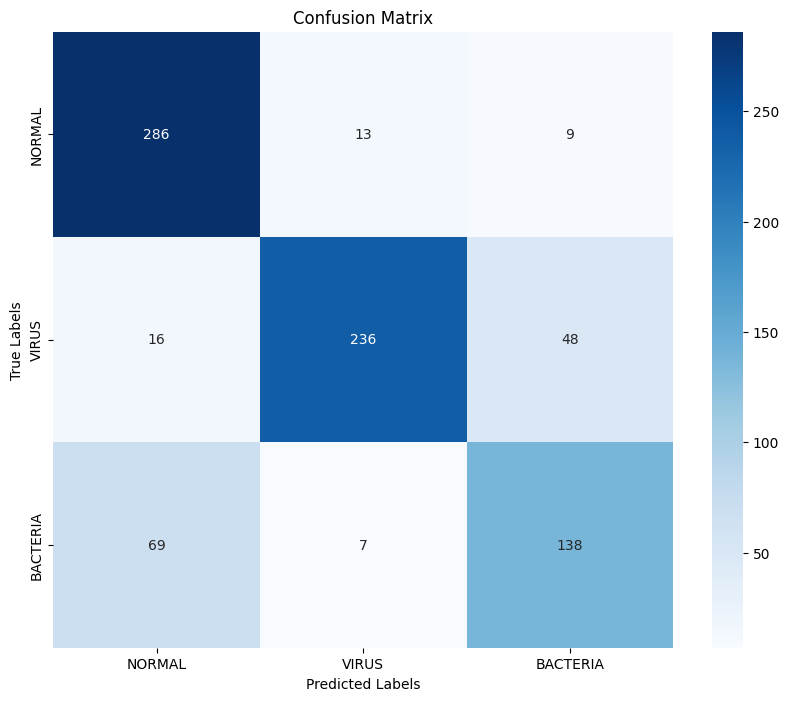

              precision    recall  f1-score   support

      NORMAL       0.77      0.93      0.84       308
       VIRUS       0.92      0.79      0.85       300
    BACTERIA       0.71      0.64      0.67       214

    accuracy                           0.80       822
   macro avg       0.80      0.79      0.79       822
weighted avg       0.81      0.80      0.80       822



In [52]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)

In [53]:
# Dégelez les dernières couches du modèle de base pour le fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

In [54]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 15,212,867 (58.03 MB)

 Non-trainable params: 7,636,544 (29.13 MB)

In [55]:
history_finetune = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=40,
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7351 - loss: 5.2275 - recall_1: 0.7351
Epoch 0 - Test loss: 10.337892532348633, Test accuracy: 0.37469586730003357, Test recall: 0.37469586730003357
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 103s 64ms/step - accuracy: 0.6935 - loss: 0.9005 - recall_1: 0.6585 - val_accuracy: 0.3333 - val_loss: 9.4973 - val_recall_1: 0.3333 - learning_rate: 1.0000e-04
Epoch 2/40
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 93s 60ms/step - accuracy: 0.7019 - loss: 0.8047 - recall_1: 0.6574 - val_accuracy: 0.6528 - val_loss: 0.8563 - val_recall_1: 0.6389 - learning_rate: 1.0000e-04
Epoch 3/40
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.7346 - loss: 0.7104 - recall_1: 0.6971 - val_accuracy: 0.5556 - val_loss: 1.3234 - val_recall_1: 0.5278 - learning_rate: 1.0000e-04
Epoch 4/40
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.7424 - loss: 0.6719 - recall_1: 0.7119 - val_accuracy: 0.6285 - val_loss: 0.8842 - val_recall_1: 0.5799 - learning_rat

In [56]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8982 - loss: 0.4244 - recall_1: 0.8908
Loss on test dataset: 0.6870622038841248
Accuracy on test dataset: 0.7749391794204712
Recall on test dataset: 0.7615571618080139


In [57]:
# Sauvegarder le modèle
new_model.save('8_modele_final_fine_tuning_20_updated1_w_params.keras')

In [58]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [59]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

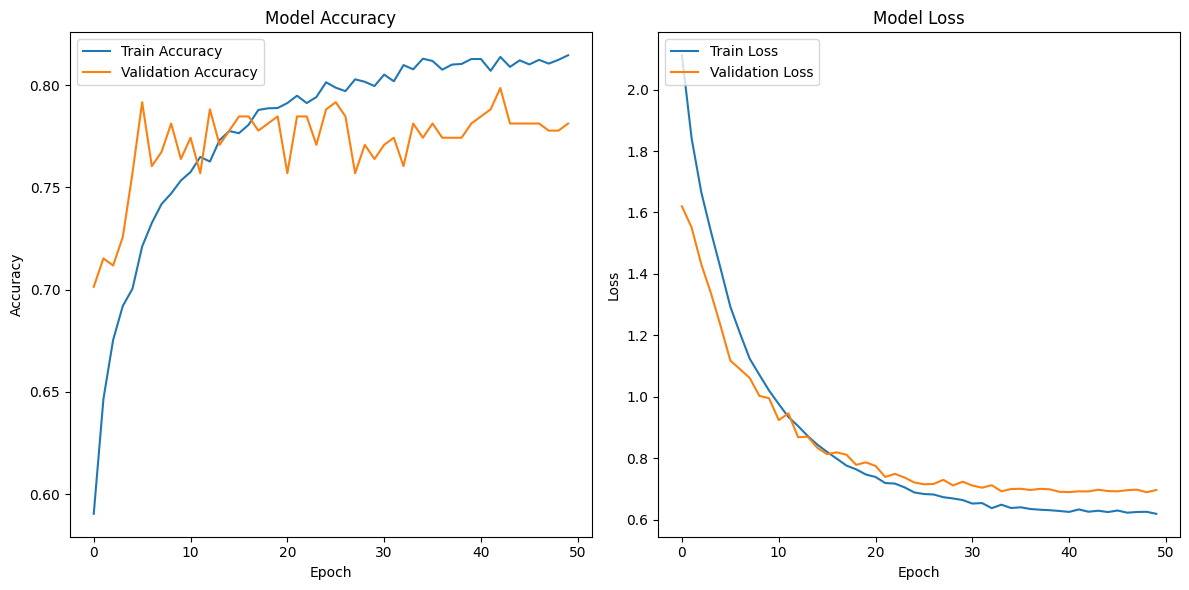

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8982 - loss: 0.4244 - recall_1: 0.8908
Loss on test dataset: 0.6870622038841248
Accuracy on test dataset: 0.7749391794204712
Recall on test dataset: 0.7615571618080139


2024-07-07 15:06:16.413586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step


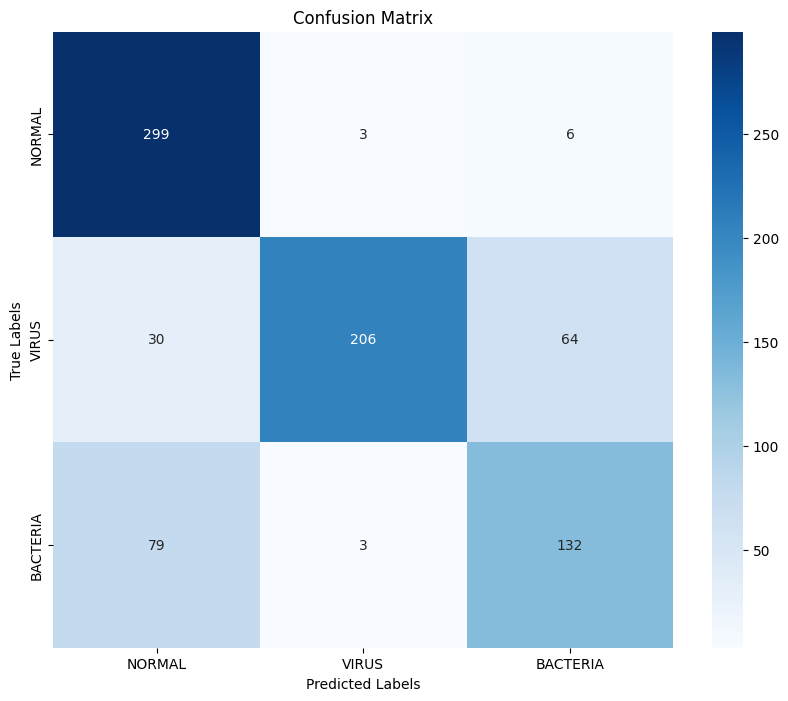

              precision    recall  f1-score   support

      NORMAL       0.73      0.97      0.84       308
       VIRUS       0.97      0.69      0.80       300
    BACTERIA       0.65      0.62      0.63       214

    accuracy                           0.77       822
   macro avg       0.79      0.76      0.76       822
weighted avg       0.80      0.77      0.77       822



In [60]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)

In [61]:
# Dégelez les 8 dernières couches du modèle de base pour le fine-tuning
for layer in base_model.layers[-8:]:
    layer.trainable = True

In [62]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 21,112,643 (80.54 MB)

 Non-trainable params: 1,736,768 (6.63 MB)

In [63]:
history_finetune_2 = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs= 30, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9130 - loss: 0.4074 - recall_2: 0.9033
Epoch 0 - Test loss: 0.579958975315094, Test accuracy: 0.8029196858406067, Test recall: 0.7895377278327942
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 149s 91ms/step - accuracy: 0.6676 - loss: 0.7677 - recall_2: 0.6215 - val_accuracy: 0.6632 - val_loss: 0.6476 - val_recall_2: 0.6493 - learning_rate: 1.0000e-04
Epoch 2/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 429s 275ms/step - accuracy: 0.7476 - loss: 0.6048 - recall_2: 0.7197 - val_accuracy: 0.6493 - val_loss: 0.6996 - val_recall_2: 0.6285 - learning_rate: 1.0000e-04
Epoch 3/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.7736 - loss: 0.5709 - recall_2: 0.7471 - val_accuracy: 0.6250 - val_loss: 0.7610 - val_recall_2: 0.5729 - learning_rate: 1.0000e-04
Epoch 4/30
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 132s 85ms/step - accuracy: 0.7609 - loss: 0.5841 - recall_2: 0.7326 - val_accuracy: 0.6806 - val_loss: 0.6325 - val_recall_2: 0.6562 - learning_ra

In [64]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9130 - loss: 0.4074 - recall_2: 0.9033
Loss on test dataset: 0.579958975315094
Accuracy on test dataset: 0.8029196858406067
Recall on test dataset: 0.7895377278327942


In [65]:
# Sauvegarder le modèle
new_model.save('8_modele_final_fine_tuning_40_updated1_w_params.keras')

In [66]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [67]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

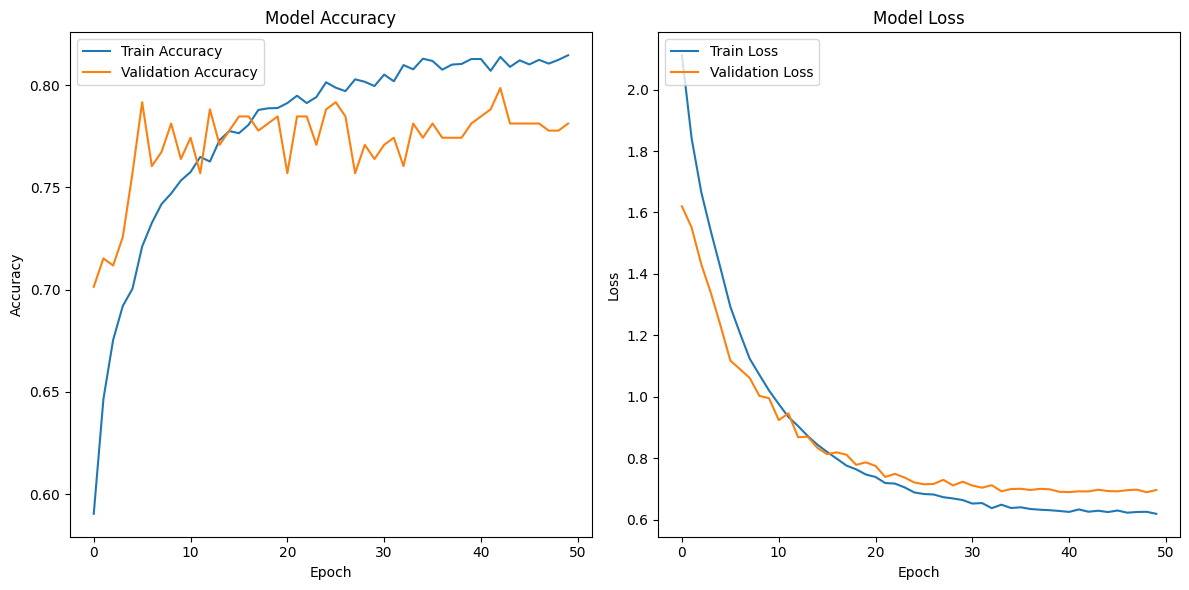

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9130 - loss: 0.4074 - recall_2: 0.9033
Loss on test dataset: 0.579958975315094
Accuracy on test dataset: 0.8029196858406067
Recall on test dataset: 0.7895377278327942


2024-07-07 15:33:50.324301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step


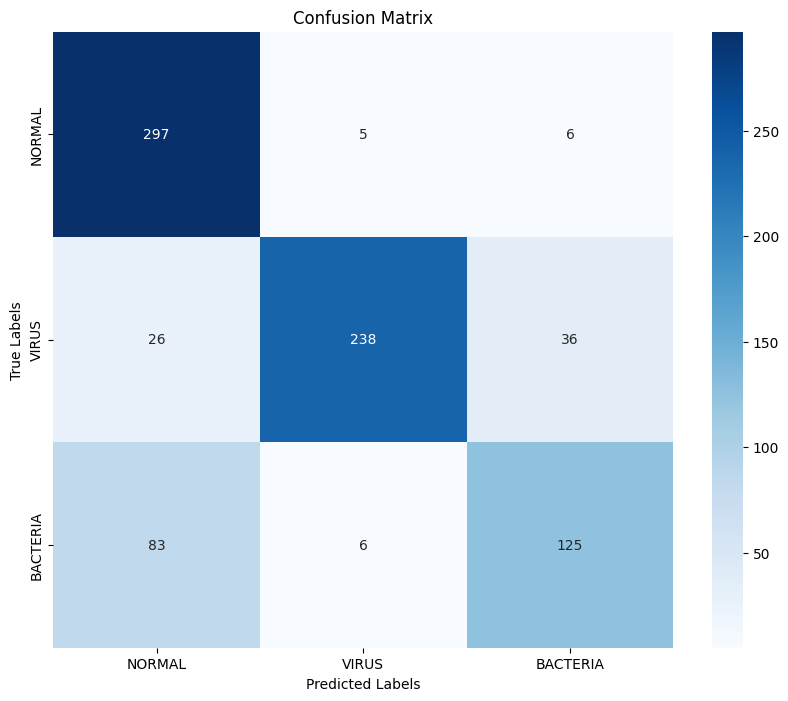

              precision    recall  f1-score   support

      NORMAL       0.73      0.96      0.83       308
       VIRUS       0.96      0.79      0.87       300
    BACTERIA       0.75      0.58      0.66       214

    accuracy                           0.80       822
   macro avg       0.81      0.78      0.79       822
weighted avg       0.82      0.80      0.80       822



In [68]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)

In [69]:
# Fine-tuning final avec toutes les couches dégélées
for layer in base_model.layers:
    layer.trainable = True

In [70]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall()])

new_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_flatten (Flatten)           │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │     8,028,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 320)            │       102,720 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,849,411 (87.16 MB)

 Trainable params: 22,848,131 (87.16 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [71]:
history_finetune_3 = new_model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=EPOCHS, 
    callbacks=callbacks,
    shuffle=True
)

Epoch 1/50


103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8136 - loss: 0.5958 - recall_3: 0.7938
Epoch 0 - Test loss: 0.6712574362754822, Test accuracy: 0.7652068138122559, Test recall: 0.7104622721672058
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 237s 148ms/step - accuracy: 0.6505 - loss: 0.7932 - recall_3: 0.5911 - val_accuracy: 0.5660 - val_loss: 1.0444 - val_recall_3: 0.5312 - learning_rate: 1.0000e-04
Epoch 2/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 222s 142ms/step - accuracy: 0.7261 - loss: 0.6565 - recall_3: 0.6854 - val_accuracy: 0.5972 - val_loss: 0.9447 - val_recall_3: 0.5729 - learning_rate: 1.0000e-04
Epoch 3/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 220s 141ms/step - accuracy: 0.7473 - loss: 0.6211 - recall_3: 0.7143 - val_accuracy: 0.6424 - val_loss: 0.6924 - val_recall_3: 0.6042 - learning_rate: 1.0000e-04
Epoch 4/50
1561/1561 ━━━━━━━━━━━━━━━━━━━━ 220s 141ms/step - accuracy: 0.7525 - loss: 0.6000 - recall_3: 0.7244 - val_accuracy: 0.6840 - val_loss: 0.6558 - val_recall_3: 0.6701 - learning_rate: 1.0

In [72]:
# Évaluation des performances sur le jeu de test
test_loss, test_accuracy, test_recall = new_model.evaluate(test_dataset)
print(f"Loss on test dataset: {test_loss}")
print(f"Accuracy on test dataset: {test_accuracy}")
print(f"Recall on test dataset: {test_recall}")

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8136 - loss: 0.5958 - recall_3: 0.7938
Loss on test dataset: 0.6712574362754822
Accuracy on test dataset: 0.7652068138122559
Recall on test dataset: 0.7104622721672058


In [73]:
# Sauvegarder le modèle
new_model.save('8_modele_final_fine_tuning_100_updated1_w_params.keras')

In [74]:
def plot_metrics(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [75]:
def evaluate_model(model, test_dataset):
    test_loss, test_accuracy, test_recall = model.evaluate(test_dataset)
    print(f"Loss on test dataset: {test_loss}")
    print(f"Accuracy on test dataset: {test_accuracy}")
    print(f"Recall on test dataset: {test_recall}")

    test_labels = np.concatenate([y for x, y in test_dataset], axis=0)
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(true_labels, predicted_labels, target_names=list(class_names.values())))

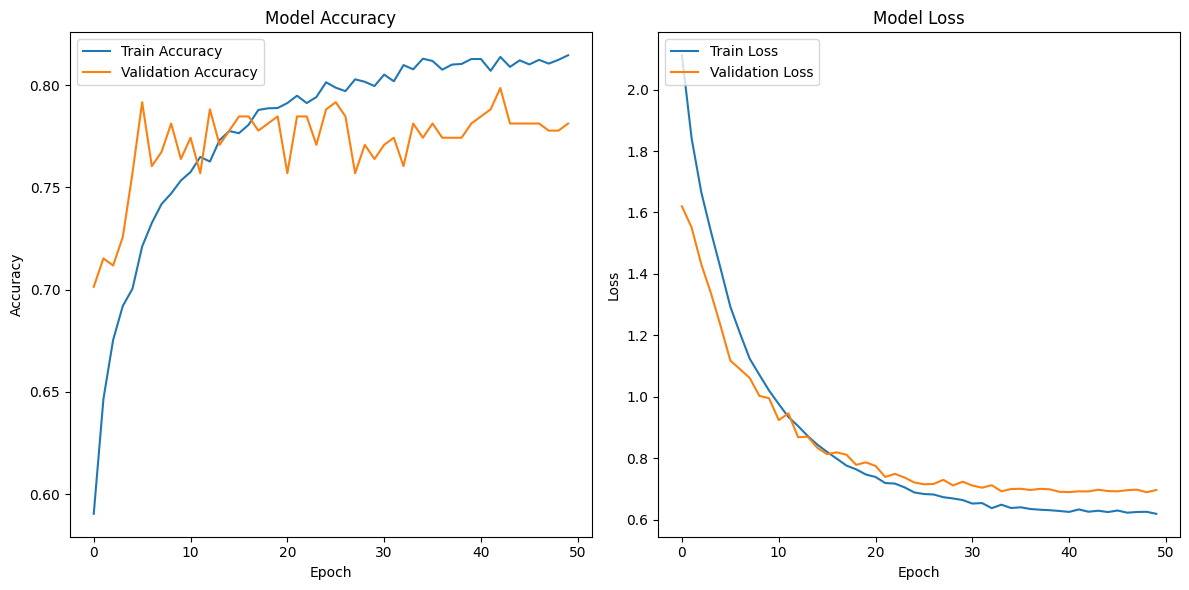

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8136 - loss: 0.5958 - recall_3: 0.7938
Loss on test dataset: 0.6712574362754822
Accuracy on test dataset: 0.7652068138122559
Recall on test dataset: 0.7104622721672058


2024-07-07 16:11:07.969570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step


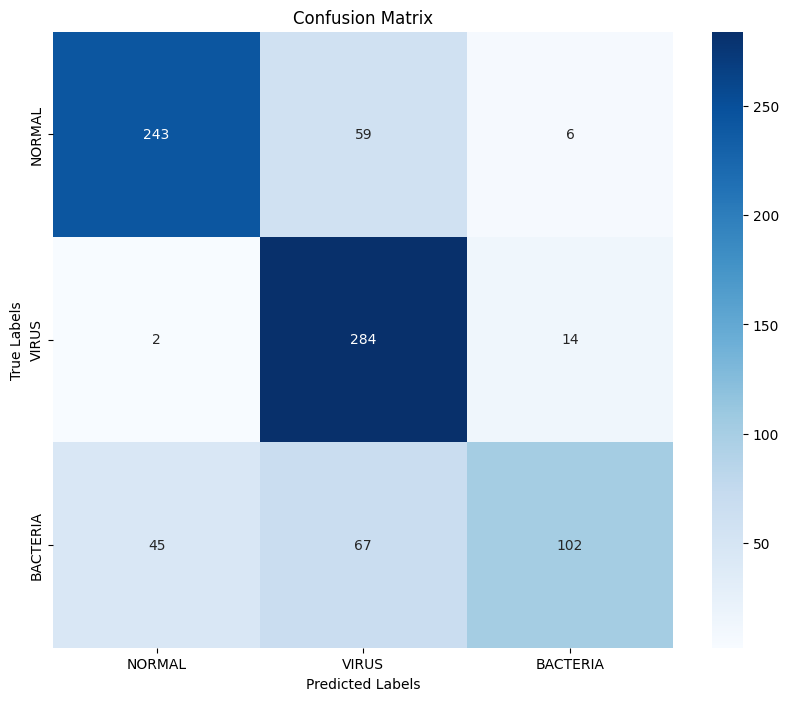

              precision    recall  f1-score   support

      NORMAL       0.84      0.79      0.81       308
       VIRUS       0.69      0.95      0.80       300
    BACTERIA       0.84      0.48      0.61       214

    accuracy                           0.77       822
   macro avg       0.79      0.74      0.74       822
weighted avg       0.78      0.77      0.75       822



In [76]:
# Tracer les courbes de précision et de perte
plot_metrics(history)

# Évaluation détaillée sur le jeu de test
evaluate_model(new_model, test_dataset)